In [26]:
# Handle all includes
%load_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spatz.utils.preprocess import preprocess_file
from spatz.simulation import Simulation, UniformTimeSteps


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Do preprocessing
PATH = "data/simulations"
TMP = f"{PATH}/temp"
FILE = "19km"

if os.path.isdir(TMP):
    shutil.rmtree(TMP)
os.mkdir(TMP)

df = preprocess_file(f"{PATH}/{FILE}.txt")
df.to_csv(f"{TMP}/{FILE}.csv")


In [28]:
# Create simulation objects
timesteps = UniformTimeSteps(0.1, mu=0, sigma=0, delay_only=True)
simulation = Simulation(timesteps)

In [36]:
from spatz.sensors.antenna.pathloss import AntennaPathloss
from spatz.sensors.antenna.tx_gain import AntennaTxGain
from spatz.sensors.antenna.constants import STAHR_LORA_FREQ, STAHR_GS_OFFSET

alt = simulation.add_observer(['altitude'])
fspl_gs = simulation.add_sensor(AntennaPathloss,frequency=STAHR_LORA_FREQ,rx_antenna_offset=STAHR_GS_OFFSET)
fspl_nope = simulation.add_sensor(AntennaPathloss,frequency=STAHR_LORA_FREQ,name)

tx_gain = simulation.add_sensor(AntennaTxGain,gain_pattern_path=f"data/gain_pattern/farfield_tx_aisler_v1.txt",rx_antenna_offset = STAHR_GS_OFFSET)

simulation.load(f"{TMP}/{FILE}.csv")
logger = simulation.get_logger()

Processed 65160 lines in 0.3s.
Used 65160 lines due to step size


In [37]:
# Run simulation
for step, t, dt in simulation.run(verbose=True):
    fspl_gs()
    fspl_nope()
    tx_gain()
    alt()

df = logger.get_dataframe()

100%|█████████▉| 579.9000000000633/580.0 [00:21<00:00, 27.40it/s] 


In [39]:
df

time antenna/pathloss/distance antenna/pathloss/out  \
0       0.1                319.472878            90.319785   
1       0.2                320.418701            90.345462   
2       0.3                321.364681            90.371068   
3       0.4                322.433254            90.399901   
4       0.5                324.359314            90.451632   
...     ...                       ...                  ...   
5794  579.5              23290.112901           127.574537   
5795  579.6              23292.369533           127.575378   
5796  579.7              23294.626207            127.57622   
5797  579.8              23296.882923           127.577061   
5798  579.9               23299.13968           127.577903   

     antenna/tx_gain/rocket_x antenna/tx_gain/rocket_y  \
0                         0.0                 0.171335   
1                         0.0                 0.171335   
2                         0.0                 0.171335   
3                        -0.0                 0.171335   
4                        -0.0                 0.171335   
...                       ...                      ...   
5794                -0.017067                -0.743764   
5795                -0.017173                -0.745696   
5796                -0.017279                -0.747621   
5797                -0.017385                -0.749539   
5798                -0.017491                -0.751452   

     antenna/tx_gain/rocket_z antenna/tx_gain/pos_x antenna/tx_gain/pos_y  \
0                    0.985213              0.750379                0.6369   
1                    0.985213              0.750342              0.636834   
2                    0.985213              0.750305              0.636768   
3                    0.985213              0.750264              0.636694   
4                    0.985213              0.750188               0.63656   
...                       ...                   ...                   ...   
5794                -0.668224              0.969129              0.022163   
5795                -0.666065              0.969119              0.022152   
5796                -0.663901              0.969109              0.022141   
5797                -0.661732                0.9691               0.02213   
5798                -0.659556               0.96909              0.022119   

     antenna/tx_gain/pos_z antenna/tx_gain/theta antenna/tx_gain/out  \
0                -0.176889             86.264551            4.977619   
1                -0.177281             86.241706            4.977825   
2                -0.177674             86.218865             4.97803   
3                -0.178116             86.193076            4.978262   
4                -0.178914             86.146622             4.97868   
...                    ...                   ...                 ...   
5794              0.245555             78.631975            4.847807   
5795              0.245595             78.653403             4.84875   
5796              0.245635             78.674921            4.849697   
5797              0.245675             78.696529            4.850647   
5798              0.245715             78.718226            4.851602   

     general/altitude  
0          319.083996  
1          319.251988  
2          319.419979  
3          319.692081  
4          320.692955  
...               ...  
5794     -2747.465778  
5795     -2748.066515  
5796     -2748.667252  
5797     -2749.267989  
5798     -2749.868726  

[5799 rows x 12 columns]

128.19324355144363


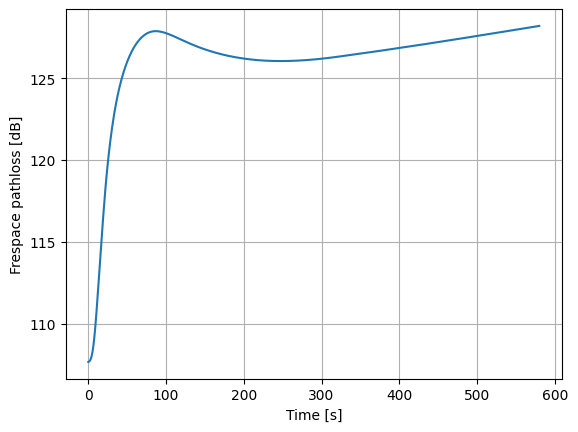

In [32]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/out'][1:], label='FSPL')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")

print(np.max(df['antenna/pathloss/out'][1:]))

23299.139680366974


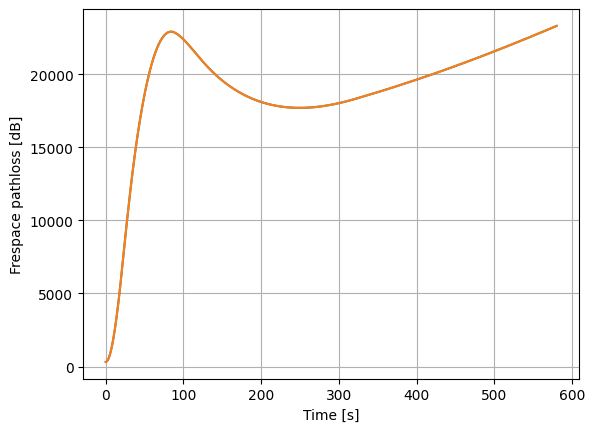

In [38]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/distance'][1:], label='Dist to GS')
plt.plot(df['time'][1:], df['antenna/pathloss/distance'][1:], label='Dist to Pad')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")

print(np.max(df['antenna/pathloss/distance'][1:]))

0.9391183839865815


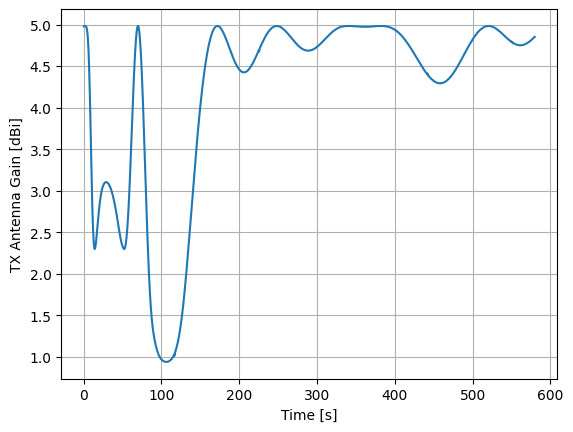

In [34]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/tx_gain/out'][1:], label='FSPL')
plt.ylabel("TX Antenna Gain [dBi]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/tx_gain/out'][1:]))

-94.78810957233904


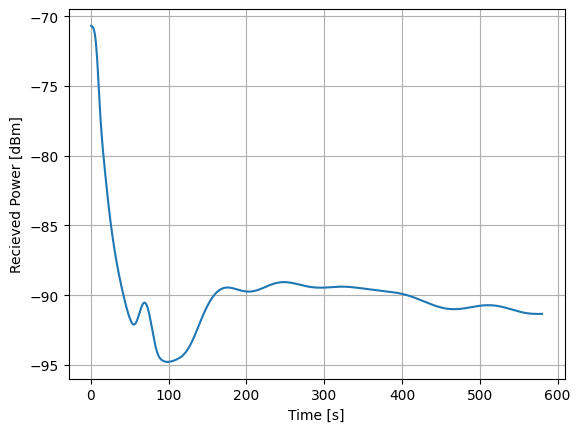

In [35]:
# Calculate recieved power
# Assumptions:  3 dB polarization loss
#               25 dBm output power per channel
#               16 dBi antenna rx gain
#               -6 dB on reciever side


df["antenna/power_rx"] = 25+df["antenna/tx_gain/out"] - df["antenna/pathloss/out"] - 3 + 16 - 6 
plt.grid()
plt.plot(df['time'][1:], df['antenna/power_rx'][1:], label='FSPL')
plt.ylabel("Recieved Power [dBm]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/power_rx'][1:]))